In [1]:
# Install required packages
!pip install tensorflow keras numpy pandas matplotlib scikit-learn pillow opencv-python seaborn gradio


Defaulting to user installation because normal site-packages is not writeable
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.

The conflict is caused by:
    The user requested numpy
    tensorflow 2.20.0 depends on numpy>=1.26.0
    keras 3.11.3 depends on numpy
    pandas 2.3.2 depends on numpy>=1.26.0; python_version >= "3.12"
    matplotlib 3.10.6 depends on numpy>=1.23
    scikit-learn 1.5.1 depends on numpy>=1.19.5
    opencv-python 4.12.0.88 depends on numpy<2.3.0 and >=2; python_version >= "3.9"

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict



ERROR: Cannot install keras==3.11.3, matplotlib==3.10.6, numpy, opencv-python==4.12.0.88, pandas==2.3.2, scikit-learn==1.5.1 and tensorflow==2.20.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [2]:
pip install "numpy<2" --force-reinstall


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement numpy<2 (from versions: none)
ERROR: No matching distribution found for numpy<2


In [3]:
%pip install "numpy<2" --force-reinstall


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement numpy<2 (from versions: none)
ERROR: No matching distribution found for numpy<2


In [4]:
%pip install "numpy<2" --force-reinstall



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement numpy<2 (from versions: none)
ERROR: No matching distribution found for numpy<2


In [5]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from PIL import Image
import random

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Gradio for interface
import gradio as gr

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Dataset Analysis:
Cyst: 2301 images
Stone: 1377 images
Normal: 2752 images
Tumor: 1948 images


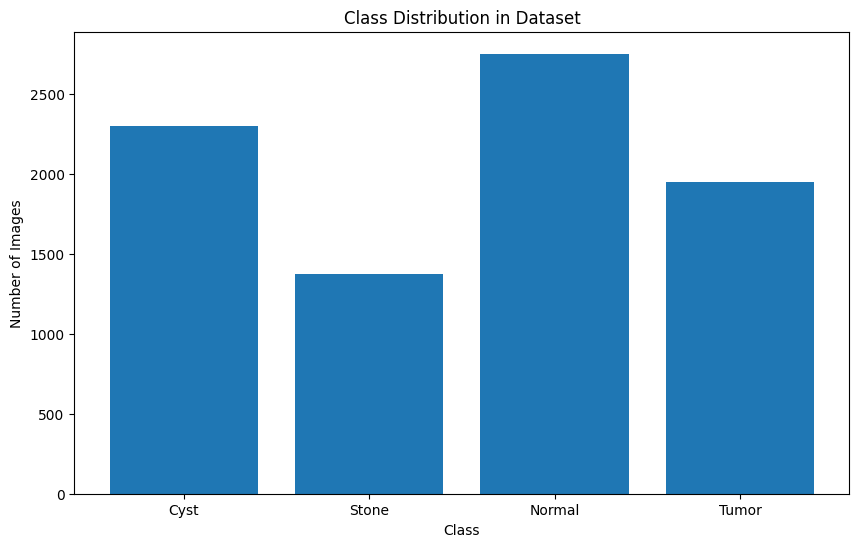

In [6]:
# Define dataset parameters
data_dir = "kidney_ct_dataset"  # Update this path to your dataset location
classes = ['Cyst', 'Stone', 'Normal', 'Tumor']
img_size = 128  # Image size for resizing

# Check dataset statistics
print("Dataset Analysis:")
class_counts = {}
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.exists(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images
        print(f"{class_name}: {num_images} images")
    else:
        print(f"Warning: Directory {class_path} does not exist!")

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [7]:
# Load images and labels
images = []
labels = []

print("Loading images...")
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.exists(class_path):
        print(f"Skipping {class_name} - directory not found")
        continue
        
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            # Read and preprocess image
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize image
            img = cv2.resize(img, (img_size, img_size))
            
            images.append(img)
            labels.append(class_idx)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]}")

# Normalize pixel values to [0, 1]
X = X / 255.0

# One-hot encode labels
y_categorical = to_categorical(y, num_classes=len(classes))

# Check the shape of our data
print(f"X shape: {X.shape}")
print(f"y shape: {y_categorical.shape}")

Loading images...
Loaded 8377 images with shape (128, 128, 3)
X shape: (8377, 128, 128, 3)
y shape: (8377, 4)


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

# Further split training data to create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 5360 samples
Validation set: 1341 samples
Test set: 1676 samples


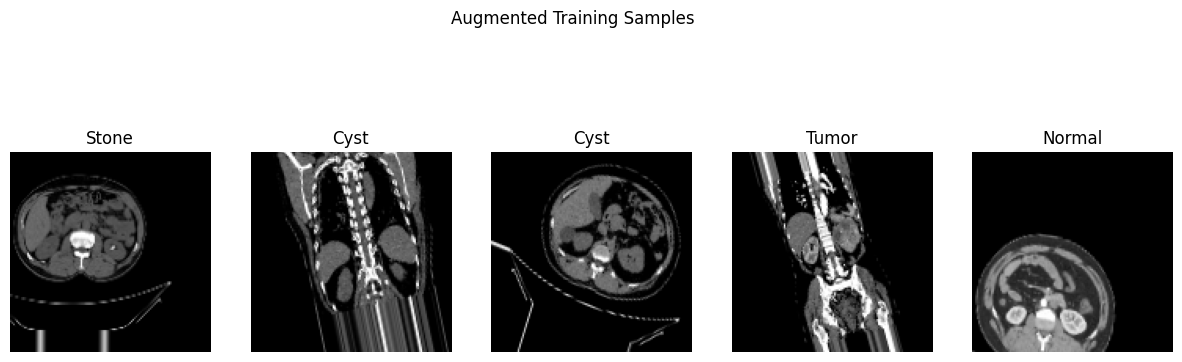

In [ ]:
# Create data generators for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

# Create iterators
batch_size = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# Display sample augmented images
def plot_augmented_samples(generator, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Get a batch of augmented images
        X_batch, y_batch = next(generator)
        
        # Display the first image in the batch
        ax = plt.subplot(1, num_samples, i+1)
        plt.imshow(X_batch[0])
        plt.title(classes[np.argmax(y_batch[0])])
        plt.axis('off')
    plt.suptitle('Augmented Training Samples')
    plt.show()

plot_augmented_samples(train_generator)

In [10]:
# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 0.9105434782608696, 1: 1.520878721859114, 2: 0.7609920058139535, 3: 1.0750770020533882}


C:\Users\manis\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,567,396 (36.50 MB)

 Trainable params: 9,565,412 (36.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Build a CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Fourth convolutional block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Classifier
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_cnn_model((img_size, img_size, 3), len(classes))

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Display model architecture
model.summary()

# Plot model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [12]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Model checkpoint to save best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_kidney_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [13]:
# Clear previous model and create a new one
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear any existing models
K.clear_session()
tf.compat.v1.reset_default_graph()

# Recreate your model
model = create_cnn_model((img_size, img_size, 3), len(classes))

# Recompile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Now train with fewer epochs
epochs = 20  # Your desired number of epochs

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/20


C:\Users\manis\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.4374 - loss: 1.5555 - precision: 0.4709 - recall: 0.3343
Epoch 1: val_accuracy improved from None to 0.27439, saving model to best_kidney_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 83s 479ms/step - accuracy: 0.5043 - loss: 1.2640 - precision: 0.5519 - recall: 0.4060 - val_accuracy: 0.2744 - val_loss: 7.4003 - val_precision: 0.2744 - val_recall: 0.2744 - learning_rate: 0.0010
Epoch 2/20
  1/167 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - accuracy: 0.4375 - loss: 1.0628 - precision: 0.5200 - recall: 0.4062

C:\Users\manis\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.27439
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4375 - loss: 1.0628 - precision: 0.5200 - recall: 0.4062 - val_accuracy: 0.2736 - val_loss: 7.4707 - val_precision: 0.2736 - val_recall: 0.2736 - learning_rate: 0.0010
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6046 - loss: 0.9925 - precision: 0.6377 - recall: 0.5300
Epoch 3: val_accuracy did not improve from 0.27439
167/167 ━━━━━━━━━━━━━━━━━━━━ 80s 481ms/step - accuracy: 0.6258 - loss: 0.9324 - precision: 0.6579 - recall: 0.5572 - val_accuracy: 0.2729 - val_loss: 4.8218 - val_precision: 0.2762 - val_recall: 0.2729 - learning_rate: 0.0010
Epoch 4/20
  1/167 ━━━━━━━━━━━━━━━━━━━━ 1:18 472ms/step - accuracy: 0.7188 - loss: 0.7334 - precision: 0.7143 - recall: 0.6250
Epoch 4: val_accuracy did not improve from 0.27439
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7188 - loss: 0.7334 - precision: 0.7143 - recall: 0.6250 - val_accuracy: 0.2736 - val_lo

167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 485ms/step - accuracy: 0.7740 - loss: 0.5858 - precision: 0.7953 - recall: 0.7425 - val_accuracy: 0.7934 - val_loss: 0.6053 - val_precision: 0.7967 - val_recall: 0.7736 - learning_rate: 0.0010
Epoch 8/20
  1/167 ━━━━━━━━━━━━━━━━━━━━ 1:17 466ms/step - accuracy: 0.8750 - loss: 0.3875 - precision: 0.8710 - recall: 0.8438
Epoch 8: val_accuracy did not improve from 0.79345
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8750 - loss: 0.3875 - precision: 0.8710 - recall: 0.8438 - val_accuracy: 0.7919 - val_loss: 0.5757 - val_precision: 0.8031 - val_recall: 0.7805 - learning_rate: 0.0010
Epoch 9/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8048 - loss: 0.5139 - precision: 0.8217 - recall: 0.7822
Epoch 9: val_accuracy did not improve from 0.79345
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 484ms/step - accuracy: 0.8157 - loss: 0.4909 - precision: 0.8328 - recall: 0.7926 - val_accuracy: 0.7226 - val_loss: 0.6946 - val_precision: 0.7258 - val_recall: 0

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8750 - loss: 0.3405 - precision: 0.8750 - recall: 0.8750 - val_accuracy: 0.8308 - val_loss: 0.4418 - val_precision: 0.8389 - val_recall: 0.8255 - learning_rate: 0.0010
Epoch 13/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8561 - loss: 0.3824 - precision: 0.8650 - recall: 0.8431
Epoch 13: val_accuracy improved from 0.83079 to 0.87652, saving model to best_kidney_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 485ms/step - accuracy: 0.8692 - loss: 0.3430 - precision: 0.8773 - recall: 0.8572 - val_accuracy: 0.8765 - val_loss: 0.2968 - val_precision: 0.8802 - val_recall: 0.8735 - learning_rate: 0.0010
Epoch 14/20
  1/167 ━━━━━━━━━━━━━━━━━━━━ 1:14 448ms/step - accuracy: 0.9375 - loss: 0.1304 - precision: 0.9677 - recall: 0.9375
Epoch 14: val_accuracy improved from 0.87652 to 0.88643, saving model to best_kidney_model.h5


167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9375 - loss: 0.1304 - precision: 0.9677 - recall: 0.9375 - val_accuracy: 0.8864 - val_loss: 0.2860 - val_precision: 0.8903 - val_recall: 0.8841 - learning_rate: 0.0010
Epoch 15/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8724 - loss: 0.3358 - precision: 0.8827 - recall: 0.8646
Epoch 15: val_accuracy did not improve from 0.88643
167/167 ━━━━━━━━━━━━━━━━━━━━ 81s 483ms/step - accuracy: 0.8701 - loss: 0.3360 - precision: 0.8801 - recall: 0.8613 - val_accuracy: 0.8095 - val_loss: 0.5296 - val_precision: 0.8217 - val_recall: 0.7973 - learning_rate: 0.0010
Epoch 16/20
  1/167 ━━━━━━━━━━━━━━━━━━━━ 1:14 449ms/step - accuracy: 0.9062 - loss: 0.2367 - precision: 0.9062 - recall: 0.9062
Epoch 16: val_accuracy did not improve from 0.88643
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9062 - loss: 0.2367 - precision: 0.9062 - recall: 0.9062 - val_accuracy: 0.8133 - val_loss: 0.5168 - val_precision: 0.8244 - val_recall:

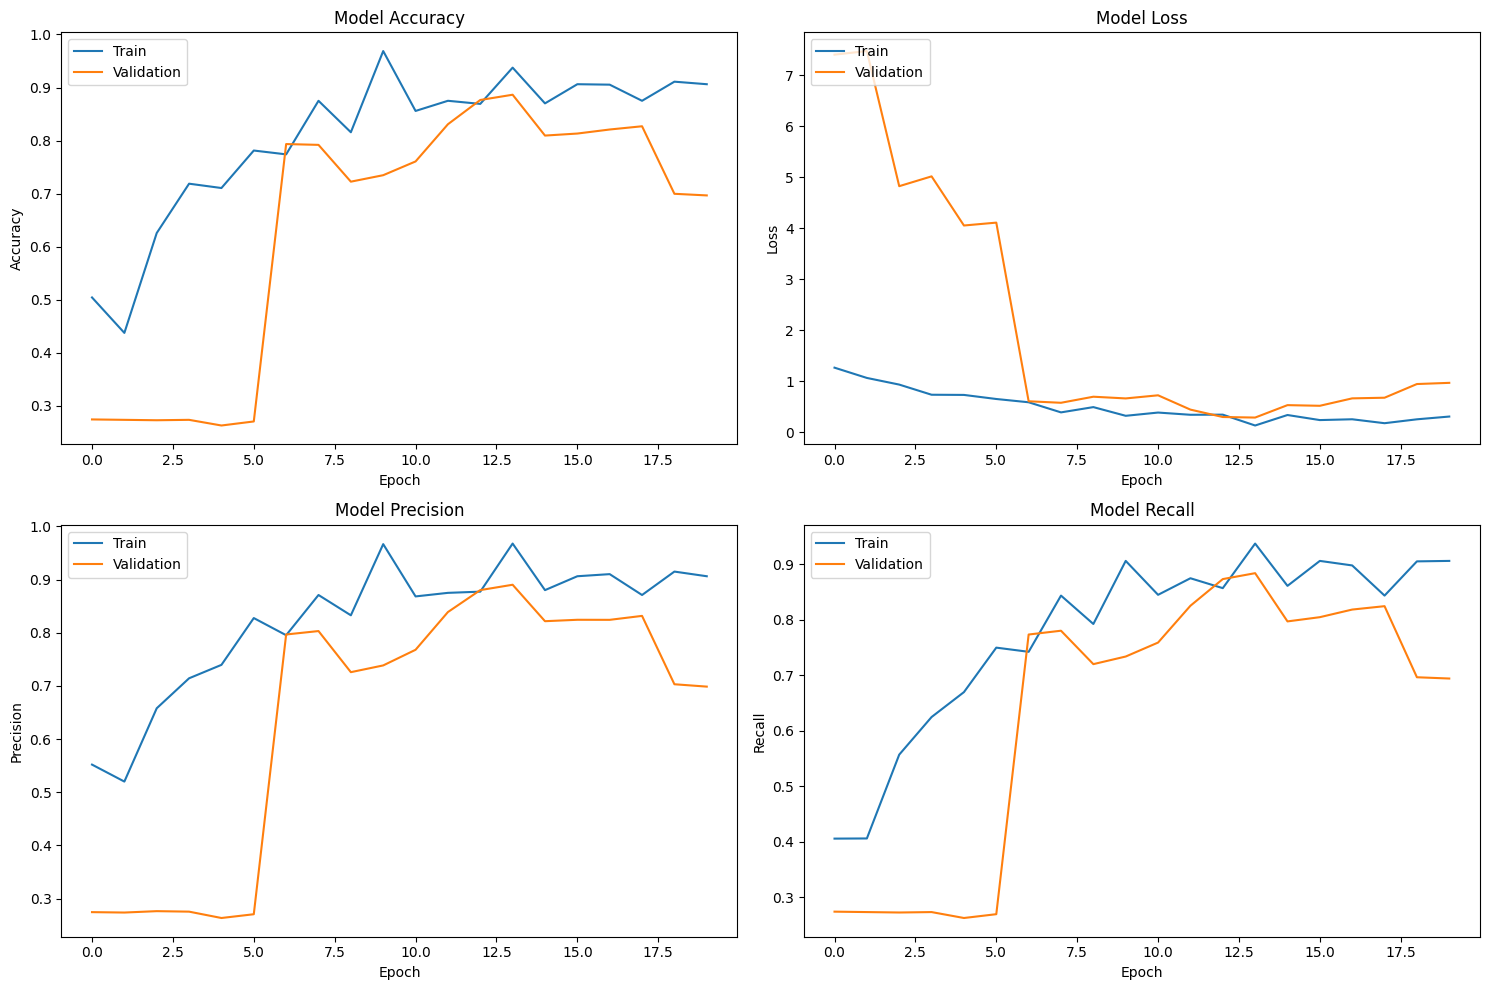

Test Accuracy: 0.8938
Test Precision: 0.8973
Test Recall: 0.8914
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.89      0.92      0.91       460
       Stone       0.84      0.81      0.83       275
      Normal       0.91      0.94      0.93       551
       Tumor       0.91      0.85      0.88       390

    accuracy                           0.89      1676
   macro avg       0.89      0.88      0.88      1676
weighted avg       0.89      0.89      0.89      1676



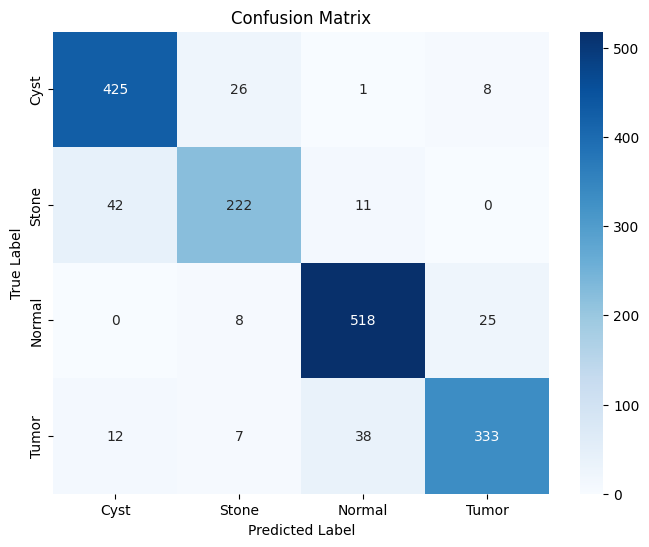

In [14]:
# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'])
    axes[0, 0].plot(history.history['val_accuracy'])
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'])
    axes[0, 1].plot(history.history['val_loss'])
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot precision
    axes[1, 0].plot(history.history['precision'])
    axes[1, 0].plot(history.history['val_precision'])
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot recall
    axes[1, 1].plot(history.history['recall'])
    axes[1, 1].plot(history.history['val_recall'])
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate on test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Save the final model
model.save('kidney_disease_cnn_final.h5')
print("Model saved as 'kidney_disease_cnn_final.h5'")

# Convert to TensorFlow Lite for potential deployment (optional)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('kidney_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TensorFlow Lite model saved as 'kidney_model.tflite'")

Model saved as 'kidney_disease_cnn_final.h5'
INFO:tensorflow:Assets written to: C:\Users\manis\AppData\Local\Temp\tmp0br8qqu6\assets


INFO:tensorflow:Assets written to: C:\Users\manis\AppData\Local\Temp\tmp0br8qqu6\assets


Saved artifact at 'C:\Users\manis\AppData\Local\Temp\tmp0br8qqu6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2119089978256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119089978832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119089978064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119091454992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119089976720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119089977104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119091454608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119091454800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119089978448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2119089976144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21198

In [16]:
# Create a function for prediction
def predict_kidney_disease(img_path, model_path='kidney_disease_cnn_final.h5'):
    # Load model if not already loaded
    if not hasattr(predict_kidney_disease, 'model'):x
        predict_kidney_disease.model = tf.keras.models.load_model(model_path)
    
    # Read and preprocess image
    img = cv2.imread(img_path)
    if img is None:
        return "Error: Could not read image"
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Make prediction
    prediction = predict_kidney_disease.model.predict(img)[0]
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    # Create result dictionary
    result = {
        'prediction': predicted_class,
        'confidence': float(confidence),
        'all_predictions': {classes[i]: float(prediction[i]) for i in range(len(classes))}
    }
    
    return result

# Test the prediction function with a sample image
sample_image_path = "tumor_test.jpg"  # Replace with actual path
if os.path.exists(sample_image_path):
    result = predict_kidney_disease(sample_image_path)
    print("Prediction Result:")
    print(f"Class: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("All probabilities:")
    for class_name, prob in result['all_predictions'].items():
        print(f"  {class_name}: {prob:.4f}")
else:
    print("Sample image not found. Please update the path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Prediction Result:
Class: Tumor
Confidence: 0.9932
All probabilities:
  Cyst: 0.0001
  Stone: 0.0001
  Normal: 0.0066
  Tumor: 0.9932


In [ ]:
# 1. Install required packages (run this first)
!pip install xgboost scikit-learn gradio

# 2. Import libraries
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import joblib
import json

Defaulting to user installation because normal site-packages is not writeable


In [18]:
# Let the code automatically choose the best layer
def find_best_feature_layer(model):
    """
    Automatically find the best layer for feature extraction
    """
    best_layer = None
    best_layer_index = -1
    
    # Look for the last dense layer before the output
    for i in range(len(model.layers)-2, -1, -1):  # Start from second-to-last layer
        layer = model.layers[i]
        layer_type = type(layer).__name__.lower()
        
        if 'dense' in layer_type or 'flatten' in layer_type:
            best_layer = layer.name
            best_layer_index = i
            print(f"Found dense/flatten layer: {i}: {layer.name}")
            break
    
    # If no dense layer found, look for the last convolutional layer
    if best_layer is None:
        for i in range(len(model.layers)-2, -1, -1):
            layer = model.layers[i]
            layer_type = type(layer).__name__.lower()
            
            if 'conv' in layer_type or 'pool' in layer_type:
                best_layer = layer.name
                best_layer_index = i
                print(f"Found conv/pool layer: {i}: {layer.name}")
                break
    
    # If still nothing, use the second-to-last layer
    if best_layer is None and len(model.layers) >= 2:
        best_layer = model.layers[-2].name
        best_layer_index = len(model.layers)-2
        print(f"Using second-to-last layer: {best_layer_index}: {best_layer}")
    
    return best_layer, best_layer_index

# Automatically find the best layer
print("Automatically finding best layer for feature extraction...")
best_layer_name, best_layer_index = find_best_feature_layer(model)

print(f"\n🎯 Recommended layer: {best_layer_name} (index {best_layer_index})")

Automatically finding best layer for feature extraction...
Found dense/flatten layer: 21: dense

🎯 Recommended layer: dense (index 21)


In [19]:
# 2. CREATE FEATURE EXTRACTOR - FIXED VERSION
print(f"🛠️ Creating feature extractor using layer: {best_layer_name}")

def create_feature_extractor(model, layer_name):
    """
    Create a model that outputs features from a specific layer
    """
    try:
        # First, ensure the model is built by calling it on a sample input
        # This will establish the input/output tensors
        dummy_input = tf.ones((1, *model.input_shape[1:]))
        _ = model(dummy_input)
        
        # Now create the feature extractor
        feature_extractor = tf.keras.Model(
            inputs=model.inputs,
            outputs=model.get_layer(layer_name).output
        )
        print(f"✅ Feature extractor created successfully using layer: {layer_name}")
        return feature_extractor
    except Exception as e:
        print(f"❌ Error creating feature extractor: {e}")
        print("Trying fallback approach...")
        
        # Fallback: create a sequential model without the last layer
        feature_extractor = tf.keras.Sequential()
        for layer in model.layers[:-1]:  # Exclude the last layer (output)
            feature_extractor.add(layer)
        
        # Ensure it's built
        dummy_input = tf.ones((1, *model.input_shape[1:]))
        _ = feature_extractor(dummy_input)
        
        print(f"✅ Fallback feature extractor created (excludes last layer)")
        return feature_extractor

# Create feature extractor
feature_extractor = create_feature_extractor(model, best_layer_name)

# Test it with one sample
print("🧪 Testing feature extractor...")
test_sample = X_train[:1]
test_features = feature_extractor.predict(test_sample, verbose=0)
print(f"✅ Feature extraction successful!")
print(f"📥 Input shape: {test_sample.shape}")
print(f"📤 Output features shape: {test_features.shape}")

🛠️ Creating feature extractor using layer: dense
✅ Feature extractor created successfully using layer: dense
🧪 Testing feature extractor...
✅ Feature extraction successful!
📥 Input shape: (1, 128, 128, 3)
📤 Output features shape: (1, 512)


In [20]:
# 3. EXTRACT FEATURES FOR ALL DATA AND SAVE TO CSV
print("📊 Extracting features for all images...")

def extract_features_batch(feature_extractor, images, batch_size=32):
    features = []
    num_batches = int(np.ceil(len(images) / batch_size))
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(images))
        batch = images[start_idx:end_idx]
        
        batch_features = feature_extractor.predict(batch, verbose=0)
        features.append(batch_features)
        
        if (i + 1) % 10 == 0 or (i + 1) == num_batches:
            print(f"📈 Processed {end_idx}/{len(images)} images")
    
    return np.vstack(features)

# Extract features
X_train_features = extract_features_batch(feature_extractor, X_train)
X_test_features = extract_features_batch(feature_extractor, X_test)
X_val_features = extract_features_batch(feature_extractor, X_val)

# Get the true labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Save features to CSV files
def save_features_to_csv(features, labels, filename, class_names):
    # Create a DataFrame for features
    feature_df = pd.DataFrame(features)
    # Add label column
    feature_df['label'] = labels
    # Add class name column
    feature_df['class_name'] = [class_names[label] for label in labels]
    # Save to CSV
    feature_df.to_csv(filename, index=False)
    print(f"✅ Saved features to {filename}")

# Save training, validation, and test features
save_features_to_csv(X_train_features, y_train_labels, 'train_features.csv', classes)
save_features_to_csv(X_val_features, y_val_labels, 'val_features.csv', classes)
save_features_to_csv(X_test_features, y_test_labels, 'test_features.csv', classes)

print(f"✅ Feature extraction completed!")
print(f"📊 Training features: {X_train_features.shape}")
print(f"📊 Test features: {X_test_features.shape}")
print(f"📊 Validation features: {X_val_features.shape}")


📊 Extracting features for all images...


📈 Processed 320/5360 images
📈 Processed 640/5360 images
📈 Processed 960/5360 images
📈 Processed 1280/5360 images
📈 Processed 1600/5360 images
📈 Processed 1920/5360 images
📈 Processed 2240/5360 images
📈 Processed 2560/5360 images
📈 Processed 2880/5360 images
📈 Processed 3200/5360 images
📈 Processed 3520/5360 images
📈 Processed 3840/5360 images
📈 Processed 4160/5360 images
📈 Processed 4480/5360 images
📈 Processed 4800/5360 images
📈 Processed 5120/5360 images
📈 Processed 5360/5360 images
📈 Processed 320/1676 images
📈 Processed 640/1676 images
📈 Processed 960/1676 images
📈 Processed 1280/1676 images
📈 Processed 1600/1676 images
📈 Processed 1676/1676 images
📈 Processed 320/1341 images
📈 Processed 640/1341 images
📈 Processed 960/1341 images
📈 Processed 1280/1341 images
📈 Processed 1341/1341 images
✅ Saved features to train_features.csv
✅ Saved features to val_features.csv
✅ Saved features to test_features.csv
✅ Feature extraction completed!
📊 Training features: (5360, 512)
📊 Test features: (

In [21]:
# --- MODIFIED XGBoost Training Section ---
# 5. TRAIN XGBOOST ON CNN FEATURES (NO NEED TO RELOAD FROM CSV)
print("🌳 Training XGBoost model on CNN features...")

# We already have the features in memory, so no need to reload from CSV
print(f"📊 Using training features: {X_train_features.shape}")
print(f"📊 Using validation features: {X_val_features.shape}")
print(f"📊 Using test features: {X_test_features.shape}")

# Create and configure XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

# Train the XGBoost model
print("⏳ Training XGBoost...")
xgb_model.fit(X_train_features, y_train_labels)

# Evaluate on validation set
xgb_val_pred = xgb_model.predict(X_val_features)
xgb_val_accuracy = accuracy_score(y_val_labels, xgb_val_pred)
print(f"✅ XGBoost Validation Accuracy: {xgb_val_accuracy:.4f}")

# Evaluate on test set
xgb_test_pred = xgb_model.predict(X_test_features)
xgb_test_accuracy = accuracy_score(y_test_labels, xgb_test_pred)
print(f"✅ XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")

# Compare with CNN performance
cnn_test_pred = np.argmax(model.predict(X_test), axis=1)
cnn_test_accuracy = accuracy_score(y_test_labels, cnn_test_pred)
print(f"📊 CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# Show which model performed better
if xgb_test_accuracy > cnn_test_accuracy:
    print("🎉 XGBoost outperformed CNN!")
elif xgb_test_accuracy < cnn_test_accuracy:
    print("🎯 CNN outperformed XGBoost!")
else:
    print("🤝 Both models performed equally!")

🌳 Training XGBoost model on CNN features...
📊 Using training features: (5360, 512)
📊 Using validation features: (1341, 512)
📊 Using test features: (1676, 512)
⏳ Training XGBoost...
✅ XGBoost Validation Accuracy: 0.9851
✅ XGBoost Test Accuracy: 0.9893
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step
📊 CNN Test Accuracy: 0.8938
🎉 XGBoost outperformed CNN!


In [22]:
# 6. CREATE HYBRID CNN-XGBOOST MODEL
print("🤝 Creating hybrid CNN-XGBoost model...")

class HybridModel:
    def __init__(self, cnn_model, xgb_model, feature_extractor, weight_cnn=0.5, weight_xgb=0.5):
        self.cnn_model = cnn_model
        self.xgb_model = xgb_model
        self.feature_extractor = feature_extractor
        self.weight_cnn = weight_cnn
        self.weight_xgb = weight_xgb
        self.classes = classes
        
    def predict(self, X):
        # Get CNN predictions (probabilities)
        cnn_probs = self.cnn_model.predict(X)
        
        # Get XGBoost predictions (probabilities)
        features = self.feature_extractor.predict(X)
        xgb_probs = self.xgb_model.predict_proba(features)
        
        # Combine predictions with weights
        combined_probs = (self.weight_cnn * cnn_probs + self.weight_xgb * xgb_probs)
        
        return combined_probs
    
    def predict_class(self, X):
        probs = self.predict(X)
        return np.argmax(probs, axis=1)

# Create hybrid model (you can adjust weights)
hybrid_model = HybridModel(model, xgb_model, feature_extractor, weight_cnn=0.6, weight_xgb=0.4)
print("✅ Hybrid model created!")

# Test hybrid model on a few samples
print("🧪 Testing hybrid model on first 5 samples...")
hybrid_preds = hybrid_model.predict_class(X_test[:5])
true_labels = y_test_labels[:5]

for i, (true, pred) in enumerate(zip(true_labels, hybrid_preds)):
    print(f"Sample {i+1}: True={classes[true]}, Pred={classes[pred]}")


🤝 Creating hybrid CNN-XGBoost model...
✅ Hybrid model created!
🧪 Testing hybrid model on first 5 samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sample 1: True=Tumor, Pred=Tumor
Sample 2: True=Cyst, Pred=Cyst
Sample 3: True=Tumor, Pred=Tumor
Sample 4: True=Tumor, Pred=Tumor
Sample 5: True=Cyst, Pred=Cyst


In [23]:
# 7. ENHANCED PREDICTION FUNCTION WITH MODEL SELECTION
print("🎯 Creating enhanced prediction function...")

def predict_kidney_disease_enhanced(img_path, model_type='hybrid'):
    """
    Enhanced prediction function with model selection
    model_type: 'cnn', 'xgb', or 'hybrid'
    """
    # Read and preprocess image
    img = cv2.imread(img_path)
    if img is None:
        return {"error": "Could not read image"}
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Make prediction based on model type
    if model_type == 'cnn':
        prediction = model.predict(img, verbose=0)[0]
    elif model_type == 'xgb':
        features = feature_extractor.predict(img, verbose=0)
        prediction = xgb_model.predict_proba(features)[0]
    else:  # hybrid
        cnn_pred = model.predict(img, verbose=0)[0]
        features = feature_extractor.predict(img, verbose=0)
        xgb_pred = xgb_model.predict_proba(features)[0]
        prediction = 0.6 * cnn_pred + 0.4 * xgb_pred  # Weighted average
    
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction)
    
    # Create result dictionary
    result = {
        'prediction': predicted_class,
        'confidence': float(confidence),
        'model_type': model_type,
        'all_predictions': {classes[i]: float(prediction[i]) for i in range(len(classes))}
    }
    
    return result

# Test the enhanced prediction function
print("🧪 Testing enhanced prediction function...")
try:
    result = predict_kidney_disease_enhanced(sample_image_path, 'hybrid')
    print(f"✅ Prediction successful!")
    print(f"   Model: {result['model_type']}")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Confidence: {result['confidence']:.4f}")
except Exception as e:
    print(f"❌ Prediction test failed: {e}")
    print("ℹ️ Make sure sample_image_path is defined or use a different image path")

🎯 Creating enhanced prediction function...
🧪 Testing enhanced prediction function...
✅ Prediction successful!
   Model: hybrid
   Prediction: Tumor
   Confidence: 0.9898


📊 COMPARING ALL MODELS...
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step
📈 CNN Test Accuracy: 0.8938
📈 XGBoost Test Accuracy: 0.9893
📈 Hybrid Model Test Accuracy: 0.9666


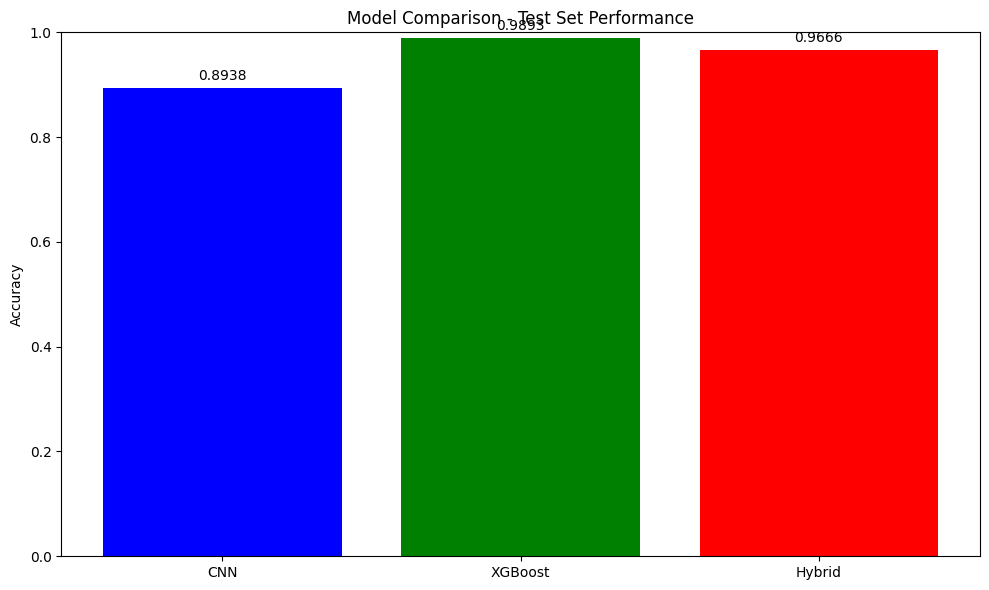

🏆 Best performing model: XGBoost (0.9893)


In [24]:
# 8. COMPARE ALL THREE MODELS
print("📊 COMPARING ALL MODELS...")

# CNN predictions
cnn_pred_probs = model.predict(X_test, verbose=0)
cnn_preds = np.argmax(cnn_pred_probs, axis=1)
cnn_accuracy = accuracy_score(y_test_labels, cnn_preds)

# XGBoost predictions
xgb_features = feature_extractor.predict(X_test, verbose=0)
xgb_preds = xgb_model.predict(xgb_features)
xgb_accuracy = accuracy_score(y_test_labels, xgb_preds)

# Hybrid predictions
hybrid_preds = hybrid_model.predict_class(X_test)
hybrid_accuracy = accuracy_score(y_test_labels, hybrid_preds)

# Print results
print(f"📈 CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"📈 XGBoost Test Accuracy: {xgb_accuracy:.4f}")
print(f"📈 Hybrid Model Test Accuracy: {hybrid_accuracy:.4f}")

# Plot comparison
models = ['CNN', 'XGBoost', 'Hybrid']
accuracies = [cnn_accuracy, xgb_accuracy, hybrid_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Model Comparison - Test Set Performance')
plt.ylim(0, 1)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Determine best model
best_model_idx = np.argmax(accuracies)
print(f"🏆 Best performing model: {models[best_model_idx]} ({accuracies[best_model_idx]:.4f})")

In [25]:
# 9. SAVE ALL MODELS
print("💾 Saving all models...")

# Create a directory for models if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save CNN model
model.save('saved_models/kidney_disease_cnn_final.h5')
print("✅ CNN model saved")

# Save XGBoost model
import joblib
joblib.dump(xgb_model, 'saved_models/kidney_disease_xgb_model.pkl')
print("✅ XGBoost model saved")

# Save feature extractor
feature_extractor.save('saved_models/kidney_feature_extractor.h5')
print("✅ Feature extractor saved")

# Save hybrid model configuration
hybrid_config = {
    'cnn_model_path': 'saved_models/kidney_disease_cnn_final.h5',
    'xgb_model_path': 'saved_models/kidney_disease_xgb_model.pkl',
    'feature_extractor_path': 'saved_models/kidney_feature_extractor.h5',
    'weights': [0.6, 0.4],
    'classes': classes,  # Save class names for reference
    'img_size': img_size  # Save image size for reference
}

import json
with open('saved_models/hybrid_model_config.json', 'w') as f:
    json.dump(hybrid_config, f, indent=4)
print("✅ Hybrid model configuration saved")

# Also save class names separately for easy reference
with open('saved_models/class_names.json', 'w') as f:
    json.dump(classes, f, indent=4)
print("✅ Class names saved")

print("🎉 All models saved successfully in 'saved_models' directory!")

💾 Saving all models...


✅ CNN model saved
✅ XGBoost model saved
✅ Feature extractor saved
✅ Hybrid model configuration saved
✅ Class names saved
🎉 All models saved successfully in 'saved_models' directory!
